Установка torch под cuda9.2 (такие дрова стоят на нашей машине с видюшкой)

https://varhowto.com/install-pytorch-cuda-9-2/

In [1]:
# ! pip install datasets transformers seqeval

In [2]:
# !pip install ray
# !pip install optuna

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/token-classification).

# Fine-tuning a model on a token classification task

## Ссылки на модели


```
https://huggingface.co/DeepPavlov/rubert-base-cased
https://github.com/vlarine/transformers-ru
https://huggingface.co/facebook/wmt19-ru-en
https://huggingface.co/DrMatters/rubert_cased
https://huggingface.co/bert-base-multilingual-cased
https://huggingface.co/blinoff/roberta-base-russian-v0
https://huggingface.co/bert-base-multilingual-uncased
```

In [2]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "DeepPavlov/rubert-base-cased"#"bert-base-multilingual-uncased"#"mrm8488/distilbert-base-multi-cased-finetuned-typo-detection" "distilbert-base-uncased" 
batch_size = 16
# batch_size = 32

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [1]:
#local directories
from datasets import load_dataset, load_metric
from pathlib import Path
import os
BASE_DIR = Path().cwd().parent
wikiann_dl_dir = BASE_DIR.joinpath("data/interim")

wikiann_dl_dir

PosixPath('/home/ewp/DEV/ld_ner_bert_learn/data/interim')

In [3]:
import shutil
shutil.rmtree(str(wikiann_dl_dir.joinpath('cache')))
import os

os.mkdir(str(wikiann_dl_dir.joinpath('cache')))

datasets = load_dataset(str(wikiann_dl_dir.joinpath("wikiann_local.py")), data_files=str(wikiann_dl_dir.joinpath("default.zip")), 
                        cache_dir=str(wikiann_dl_dir.joinpath('cache')))

datasets

Using custom data configuration default-c7de00f0f2af4a11


Dataset wikiann downloaded and prepared to /home/ewp/DEV/ld_ner_bert_learn/data/interim/cache/wikiann/default-c7de00f0f2af4a11/1.1.0/17ccb6068a962cf083b84a313689d0878d2588d414a754548255cbc445bb1dc2. Subsequent calls will reuse this data.


DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 9894
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 9882
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 98901
    })
})

To access an actual element, you need to select a split first, then give an index:

In [4]:
print(datasets["train"][3])

{'langs': ['ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru'], 'ner_tags': [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0], 'spans': ['ORG: ФИЛИАЛ БАНКА ВТБ ( ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ) В Г. ВОРОНЕЖЕ'], 'tokens': ['ФИЛИАЛ', 'БАНКА', 'ВТБ', '(', 'ПУБЛИЧНОЕ', 'АКЦИОНЕРНОЕ', 'ОБЩЕСТВО', ')', 'В', 'Г.', 'ВОРОНЕЖЕ', 'именуемое', 'в', 'дальнейшем', '"Подрядчик"', 'с', 'стороны']}


The labels are already coded as integer ids to be easily usable by our model, but the correspondence with the actual categories is stored in the `features` of the dataset:

In [5]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-INNKPP', 'I-INNKPP', 'B-RSKS', 'I-RSKS', 'B-STAT', 'I-STAT'], names_file=None, id=None), length=-1, id=None)

Since the labels are lists of `ClassLabel`, the actual names of the labels are nested in the `feature` attribute of the object above:

In [7]:
label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list

['O',
 'B-PER',
 'I-PER',
 'B-ORG',
 'I-ORG',
 'B-LOC',
 'I-LOC',
 'B-INNKPP',
 'I-INNKPP',
 'B-RSKS',
 'I-RSKS',
 'B-STAT',
 'I-STAT']

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [8]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))
    
show_random_elements(datasets["train"], 30)    

,langs,ner_tags,spans,tokens
0,"[ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru]","[O, O, O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, O, B-INNKPP, B-INNKPP, O, O, B-RSKS, O, O, B-ORG, I-ORG, I-ORG, I-ORG, B-STAT, O, O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, B-RSKS]","[LOC: ОБЛАСТЬ ОРЕНБУРГСКАЯ РАЙОН СЕВЕРНЫЙ СЕЛО СЕВЕРНОЕ УЛИЦА ЧАПАЕВА 49, INNKPP: 253701001, INNKPP: 6312139922, RSKS: 40441762007721810677, ORG: АО "" АЛЬФА-БАНК "", STAT: 042461063, LOC: 143404 , Московская обл , г Красногорск , ул Дачная , д 11А , оф 17, RSKS: 30685676135822162426]","[Адрес, филиала, банка, Лицензиар, ОБЛАСТЬ, ОРЕНБУРГСКАЯ, РАЙОН, СЕВЕРНЫЙ, СЕЛО, СЕВЕРНОЕ, УЛИЦА, ЧАПАЕВА, 49, тел., 253701001, 6312139922, Лицензиар, рс.сч., 40441762007721810677, Банк, Исполнитель, АО, "", АЛЬФА-БАНК, "", 042461063, Адрес, банка, П-щик, 143404, ,, Московская, обл, ,, г, Красногорск, ,, ул, Дачная, ,, д, 11А, ,, оф, 17, 30685676135822162426]"
1,"[ru, ru, ru, ru, ru, ru, ru, ru]","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]",[ORG: МУНИЦИПАЛЬНОЕ ОБЩЕОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ СРЕДНЯЯ ОБЩЕОБРАЗОВАТЕЛЬНАЯ ШКОЛА П.НОВОПАВЛОВКА],"[МУНИЦИПАЛЬНОЕ, ОБЩЕОБРАЗОВАТЕЛЬНОЕ, УЧРЕЖДЕНИЕ, СРЕДНЯЯ, ОБЩЕОБРАЗОВАТЕЛЬНАЯ, ШКОЛА, П.НОВОПАВЛОВКА, генеральный]"
2,"[ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru]","[O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, O, B-INNKPP, O, O, B-ORG, B-PER, I-PER, I-PER, O, B-STAT, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, B-STAT, O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, B-RSKS, B-RSKS, O, B-STAT]","[LOC: 416410 , Астраханская обл , Лиманский р-н , рп Лиман, INNKPP: 7727298791, ORG: ИП, PER: Фан Тхи Хуе, STAT: 7-876-539-84-72, ORG: ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ КОММЕРЧЕСКИЙ БАНК "" АЛТАЙКАПИТАЛБАНК "", STAT: 042911437, LOC: 249275 , Калужская обл , Сухиничский р-н , г Сухиничи , ул Энгельса , д 58, RSKS: 40262790349296356686, RSKS: 30849195398053916535, STAT: 7-864-424-04-14]","[Адрес, банка, 416410, ,, Астраханская, обл, ,, Лиманский, р-н, ,, рп, Лиман, ИНН/КПП, 7727298791, /, Плательщик, ИП, Фан, Тхи, Хуе, тел., 7-876-539-84-72, Банк, Исп-тель, ОБЩЕСТВО, С, ОГРАНИЧЕННОЙ, ОТВЕТСТВЕННОСТЬЮ, КОММЕРЧЕСКИЙ, БАНК, "", АЛТАЙКАПИТАЛБАНК, "", БИК, 042911437, Адрес, Получатель, 249275, ,, Калужская, обл, ,, Сухиничский, р-н, ,, г, Сухиничи, ,, ул, Энгельса, ,, д, 58, 40262790349296356686, 30849195398053916535, тел., 7-864-424-04-14]"
3,"[ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru, ru]","[O, O, O, O, B-STAT, I-STAT, I-STAT, I-STAT, I-STAT, B-INNKPP, O, O, B-STAT, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, O, B-STAT, I-STAT, I-STAT, I-STAT, O, O, B-RSKS, B-RSKS]","[STAT: +8 350 204 12 49, INNKPP: 381201062287, STAT: 049629695, ORG: ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "" ВКУСНО СЫТНО БЫСТРО "", LOC: КРАЙ КРАСНОЯРСКИЙ РАЙОН УЯРСКИЙ ГОРОД УЯР УЛИЦА ТИМИРЯЗЕВА 6 - -, STAT: +7-( 883 ) -384-7865, RSKS: 41069219129380319805, RSKS: 30362581872467107232]","[Инвестор, Адрес, банка, тел., +8, 350, 204, 12, 49, 381201062287, БИК, Банка, 049629695, ОБЩЕСТВО, С, ОГРАНИЧЕННОЙ, ОТВЕТСТВЕННОСТЬЮ, "", ВКУСНО, СЫТНО, БЫСТРО, "", Адрес, банка, КРАЙ, КРАСНОЯРСКИЙ, РАЙОН, УЯРСКИЙ, ГОРОД, УЯР, УЛИЦА, ТИМИРЯЗЕВА, 6, -, -, тел., +7-(, 883, ), -384-7865, р., счет, 41069219129380319805, 3036258

In [16]:
def get_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    return pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))
    
df = get_random_elements(datasets["test"], 1000) 

In [18]:
df[['spans', 'tokens']]#.to_excel(str(wikiann_dl_dir.joinpath("df_test.xlsx")), engine='openpyxl', index=False)

,spans,tokens
0,"[STAT: 8 ( 935 ) 855 1436, LOC: 115162 , г Мос...","[8, (, 935, ), 855, 1436, Адрес, Зак-чик, 1151..."
1,"[INNKPP: 6119008174, LOC: РЕСПУБЛИКА ТАТАРСТАН...","[ИНН/КПП, 6119008174, тел., РЕСПУБЛИКА, ТАТАРС..."
2,"[ORG: ИП, PER: Яковлева О. А. ,., PER: Греф Ге...","[ИП, Яковлева, О., А., ,., именуемое, в, в, ли..."
3,"[LOC: 410012 , Саратовская обл , г Саратов , Ф...","[Адрес, филиала, банка, Подрядчик, 410012, ,, ..."
4,"[PER: Ефимова Наталья Ивановна ,, STAT: +8-826...","[Исполнитель, Индивидуальный, предприниматель,..."
...,...,...
995,"[ORG: ОХРАННАЯ ОРГАНИЗАЦИЯ МИТАЗ ООО, INNKPP: ...","[ОХРАННАЯ, ОРГАНИЗАЦИЯ, МИТАЗ, ООО, Покупатель..."
996,"[ORG: Индивидуальный предприниматель, PER: Чес...","[Субподрядчик, Индивидуальный, предприниматель..."
997,[ORG: ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ...,"[Исп-тель, ОБЩЕСТВО, С, ОГРАНИЧЕННОЙ, ОТВЕТСТВ..."
998,[LOC: КРАЙ КРАСНОДАРСКИЙ РАЙОН ТИМАШЕВСКИЙ ГОР...,"[Исполнитель, Адрес, Клиент, КРАЙ, КРАСНОДАРСК..."


## Preprocessing the data

In [10]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, do_lower_case=True)

In [11]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
# assert isinstance(tokenizer, transformers.PreTrainedTokenizer)

In [12]:
# tokenizer("Hello, this is one sentence!")

tokenizer('ИП Панькова В. Б. ООО "Гарант-СВ"')

{'input_ids': [101, 74845, 15360, 38418, 7241, 845, 132, 843, 132, 612, 44967, 108, 18141, 130, 2060, 108, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

If, as is the case here, your inputs have already been split into words, you should pass the list of words to your tokenzier with the argument `is_split_into_words=True`:

In [13]:
# tokenizer(["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."], is_split_into_words=True)

tokenizer(["Привет", ",", "это", "одно", "предложение", ",", "разбитое", "на", "слова", "."], is_split_into_words=True)

{'input_ids': [101, 26856, 128, 3998, 7635, 16541, 128, 91926, 842, 1469, 11401, 132, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Note that transformers are often pretrained with subword tokenizers, meaning that even if your inputs have been split into words already, each of those words could be split again by the tokenizer. Let's look at an example of that:

In [13]:
example = datasets["train"][3]
print(example["tokens"])

['ФИЛИАЛ', 'БАНКА', 'ВТБ', '(', 'ПУБЛИЧНОЕ', 'АКЦИОНЕРНОЕ', 'ОБЩЕСТВО', ')', 'В', 'Г.', 'ВОРОНЕЖЕ', 'именуемое', 'в', 'дальнейшем', '"Подрядчик"', 'с', 'стороны']


In [15]:
example["tokens"]

['Адрес',
 'филиала',
 'банка',
 'Зак-чик',
 'Г.',
 'МОСКВА',
 'УЛ.',
 'ТРИФОНОВСКАЯ',
 'Д.',
 '45',
 'ЭТАЖ',
 '1',
 'ПОМЕЩ.',
 '1,2',
 'БИК',
 'Банка',
 '048080552',
 'к.с.',
 '30896999378158655427',
 'Филиал',
 'банка',
 'Субподрядчик',
 'ОБЩЕСТВО',
 'С',
 'ОГРАНИЧЕННОЙ',
 'ОТВЕТСТВЕННОСТЬЮ',
 '"',
 'КБ',
 'СЕГМЕНТ',
 '"',
 '7',
 '(',
 '384',
 ')',
 '744',
 '3911',
 '47933553491253138204',
 '7',
 '(',
 '322',
 ')',
 '049',
 '1136',
 'Адрес',
 'филиала',
 'банка',
 'Клиент',
 'ОБЛАСТЬ',
 'МОСКОВСКАЯ',
 'ГОРОД',
 'БАЛАШИХА',
 'ШОССЕ',
 'БАЛАШИХИНСКОЕ',
 'ДОМ',
 '20',
 'ПОМЕЩЕНИЕ',
 '361',
 'ЭТАЖ',
 '1',
 'КОМНАТА',
 '2',
 '1625000246',
 '/',
 '531001001',
 'Субподрядчик',
 'АО',
 'КБ',
 '"',
 'ВЫМПЕЛ',
 '"']

In [14]:
# tokenized_input = tokenizer(example["tokens"], is_split_into_words=True) ['ООО', '"', 'Ромашка', '"', 'ИНН','/', 'КПП', '12547896', '/', '125689523']

tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['[CLS]', 'филиал', 'банка', 'вт', '##б', '(', 'публичное', 'акционерное', 'общество', ')', 'в', 'г', '.', 'воронеж', '##е', 'имен', '##уемое', 'в', 'даль', '##не', '##ишем', '"', 'подрядчик', '"', 'с', 'стороны', '[SEP]']


As we can see, it returns a list with the same number of elements as our processed input ids, mapping special tokens to `None` and all other tokens to their respective word. This way, we can align the labels with the processed input ids.

In [16]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

27 27


Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from. Another strategy is to set the label only on the first token obtained from a given word, and give a label of -100 to the other subtokens from the same word. We propose the two strategies here, just change the value of the following flag:

In [17]:
label_all_tokens = True

We're now ready to write the function that will preprocess our samples. We feed them to the `tokenizer` with the argument `truncation=True` (to truncate texts that are bigger than the maximum size allowed by the model) and `is_split_into_words=True` (as seen above). Then we align the labels with the token ids using the strategy we picked:

In [18]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [20]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

## Fine-tuning the model

In [21]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [22]:
from transformers import DataCollatorForTokenClassification, EarlyStoppingCallback

data_collator = DataCollatorForTokenClassification(tokenizer)

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. Here we will load the [`seqeval`](https://github.com/chakki-works/seqeval) metric (which is commonly used to evaluate results on the CONLL dataset) via the Datasets library.

In [23]:
metric = load_metric("seqeval")

This metric takes list of labels for the predictions and references:

In [24]:
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

So we will need to do a bit of post-processing on our predictions:
- select the predicted index (with the maximum logit) for each token
- convert it to its string label
- ignore everywhere we set a label of -100

The following function does all this post-processing on the result of `Trainer.evaluate` (which is a namedtuple containing predictions and labels) before applying the metric:

In [25]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "f1_ORG": results["ORG"]['f1'],
        "accuracy": results["overall_accuracy"],
    }

Note that we drop the precision/recall/f1 computed for each category and only focus on the overall precision/recall/f1/accuracy.

Then we just need to pass all of this along with our datasets to the `Trainer`:

```Комментарий к строкам ниже```

https://github.com/huggingface/transformers/issues/400

I think, this will freeze all the layers including the classifier layer. (Correct me, if I'm wrong)

```
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

for param in model.bert.parameters():
    param.requires_grad = False
```
I think the below code will freeze only the BERT layers (Correct me, if I'm wrong)
```
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

for param in model.bert.bert.parameters():
    param.requires_grad = False
```

Для обучения замораживаем слои BERT

In [74]:
# Замораживаем все параметры, кроме головы = работает, но проценты не столь высокие
# for param in model.distilbert.parameters():
for param in model.bert.parameters():
    param.requires_grad = False

In [91]:
model.base_model 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [ ]:
# Смотрим сколько всего слоев Энкодела есть в архитектуре
len(model.base_model.encoder.layer[:])

### Замораживаем слои энкодера: число (10) - количество слоев заморозки, т.е. те, которые не будем дообучать

In [26]:
modules = [model.base_model.embeddings, *model.base_model.encoder.layer[:10]]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [28]:
for param in model.parameters():
    if param.requires_grad:
        print(param)

Parameter containing:
tensor([[-0.0461,  0.0168, -0.0211,  ...,  0.0252,  0.0044,  0.0400],
        [ 0.0074,  0.0186, -0.0535,  ..., -0.0113,  0.0589,  0.0542],
        [ 0.0286, -0.0870, -0.0213,  ..., -0.0543,  0.1519, -0.1215],
        ...,
        [-0.0522, -0.0585, -0.0607,  ..., -0.0495, -0.0478,  0.0259],
        [ 0.0742, -0.0310,  0.0091,  ..., -0.0221,  0.0278,  0.0749],
        [-0.0601,  0.0347, -0.0266,  ...,  0.0370, -0.0761, -0.0037]],
       requires_grad=True)
Parameter containing:
tensor([-2.4660e-01,  1.3978e-01,  1.4398e-01, -8.8893e-02, -5.8444e-02,
        -1.2504e-01, -1.1055e-01, -2.6547e-01, -3.5185e-02,  7.3766e-02,
        -9.5632e-02,  2.4231e-01,  8.9418e-02,  7.2350e-03, -1.3678e-01,
         4.6214e-02, -9.6595e-02, -1.4189e-01,  2.0293e-01, -1.4654e-01,
        -3.5274e-01,  2.8052e-01, -3.7140e-01, -2.3768e-02, -2.0438e-01,
         1.6559e-02, -3.3220e-01,  7.9950e-02, -1.2519e-01, -3.3757e-01,
         4.6691e-02, -1.2037e-01,  1.1679e-01,  5.7999e-0

In [ ]:
# разморозка = пример разморозки, не запускаем до обучения
for param in model.parameters():
    param.requires_grad = True

<code>Задаем свой оптимизатор: AdamW или Adafactor</code>

In [23]:
grouped_params = model.parameters()
optimizer=transformers.AdamW(grouped_params,
                                lr=0.002)
scheduler=transformers.get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2000, 
                                                       num_training_steps=60000)

optimizers = optimizer, scheduler

In [29]:
# Лучшие проценты

optimizer = transformers.Adafactor(
                    model.parameters(),
                    lr=1e-3,
                    eps=(1e-30, 1e-3),
                    clip_threshold=1.0,
                    decay_rate=-0.8,
                    beta1=None,
                    weight_decay=0.0,
                    relative_step=False,
                    scale_parameter=False,
                    warmup_init=False
                    )
scheduler=transformers.get_constant_schedule(optimizer=optimizer)
optimizers = optimizer, scheduler

In [30]:
args = TrainingArguments(
    f"test-{task}",
    overwrite_output_dir=True,
    evaluation_strategy = "epoch",
#     learning_rate=0.002, #2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.0, #0.01,
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #------------------
    optimizers=optimizers,
    #------------------
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [32]:
# Проверка на доступность CUDA
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

torch.backends.cudnn.benchmark=True
torch.backends.cudnn.deterministic=False

True
0
1
GeForce RTX 2060


In [110]:
import gc

gc.collect()

torch.cuda.empty_cache()

We can now finetune our model by just calling the `train` method:

In [33]:
trainer.train()

/home/ewp/.local/lib/python3.7/site-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,F1 Org,Accuracy
1,0.026100,0.022111,0.981121,0.991754,0.986409,0.901953,0.994178
2,0.019400,0.011890,0.991107,0.993474,0.992289,0.939584,0.996415
3,0.017200,0.009262,0.992605,0.995978,0.994289,0.957105,0.997214
4,0.015400,0.008591,0.993172,0.996163,0.994665,0.956002,0.997417


TrainOutput(global_step=24728, training_loss=0.02863887998518609, metrics={'train_runtime': 3856.0294, 'train_samples_per_second': 6.413, 'total_flos': 0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 2338844672, 'init_mem_gpu_alloc_delta': 709373440, 'init_mem_cpu_peaked_delta': 593502208, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 732864512, 'train_mem_gpu_alloc_delta': 59597824, 'train_mem_cpu_peaked_delta': 488169472, 'train_mem_gpu_peaked_delta': 559057408})

The `evaluate` method allows you to evaluate again on the evaluation dataset or on another dataset:

In [ ]:
trainer.evaluate()

To get the precision/recall/f1 computed for each category now that we have finished training, we can apply the same function as before on the result of the `predict` method:

In [35]:
predictions, labels, _ = trainer.predict(tokenized_datasets["train"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'INNKPP': {'precision': 0.9997715010766332,
  'recall': 0.999510871025827,
  'f1': 0.9996411690631287,
  'number': 372090},
 'LOC': {'precision': 0.9891095075812121,
  'recall': 0.9954430787397348,
  'f1': 0.9922661865692205,
  'number': 186310},
 'ORG': {'precision': 0.9481612446958981,
  'recall': 0.9694937642515896,
  'f1': 0.9587088500785397,
  'number': 207433},
 'PER': {'precision': 0.9913878562577447,
  'recall': 0.9950939406712318,
  'f1': 0.9932374413319586,
  'number': 144719},
 'RSKS': {'precision': 0.9998835684690827,
  'recall': 0.9999087405567455,
  'f1': 0.9998961543544891,
  'number': 953326},
 'STAT': {'precision': 0.9991051938746605,
  'recall': 0.9996615515942087,
  'f1': 0.9993832953032104,
  'number': 599796},
 'overall_precision': 0.9939194506334361,
 'overall_recall': 0.9966070998029771,
 'overall_f1': 0.9952614607590986,
 'overall_accuracy': 0.9977044126897887}

In [52]:
pd.DataFrame(results)

,INNKPP,LOC,ORG,PER,RSKS,STAT,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.999864,0.976269,0.931632,0.950117,0.999948,0.999559,0.990747,0.994144,0.992443,0.997347
recall,0.999891,0.995590,0.957093,0.953121,1.000000,0.999864,0.990747,0.994144,0.992443,0.997347
f1,0.999877,0.985835,0.944191,0.951617,0.999974,0.999712,0.990747,0.994144,0.992443,0.997347
number,36721.000000,18140.000000,14380.000000,14868.000000,96997.000000,58975.000000,0.990747,0.994144,0.992443,0.997347


Don't forget to [update your model](https://huggingface.co/transformers/model_sharing.html) on the [🤗 Model Hub](https://huggingface.co/models). You can then use it only to generate results like the one shown in the first picture of this notebook!

In [39]:
from sklearn.metrics import roc_curve,confusion_matrix,auc, accuracy_score
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix
    
    Draws a Confusion Matrix for better understanding of how the model is working
    
    return None
    
    '''
    
    figsize=(20,20)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [40]:
import numpy as np
# np.array(true_labels).flatten()
tl = []
tll = []
for i in true_labels:
    tl.extend([j.split('-')[-1] for j in i])
    tll.extend(i)

In [67]:
true_labels[0]
# 'O'.split('-')[-1]


['B-PER',
 'B-PER',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'B-PER',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER']

In [41]:
true_predictions

pl = []
pll = []
for i in true_predictions:
    pl.extend([j.split('-')[-1] for j in i])
    pll.extend(i)

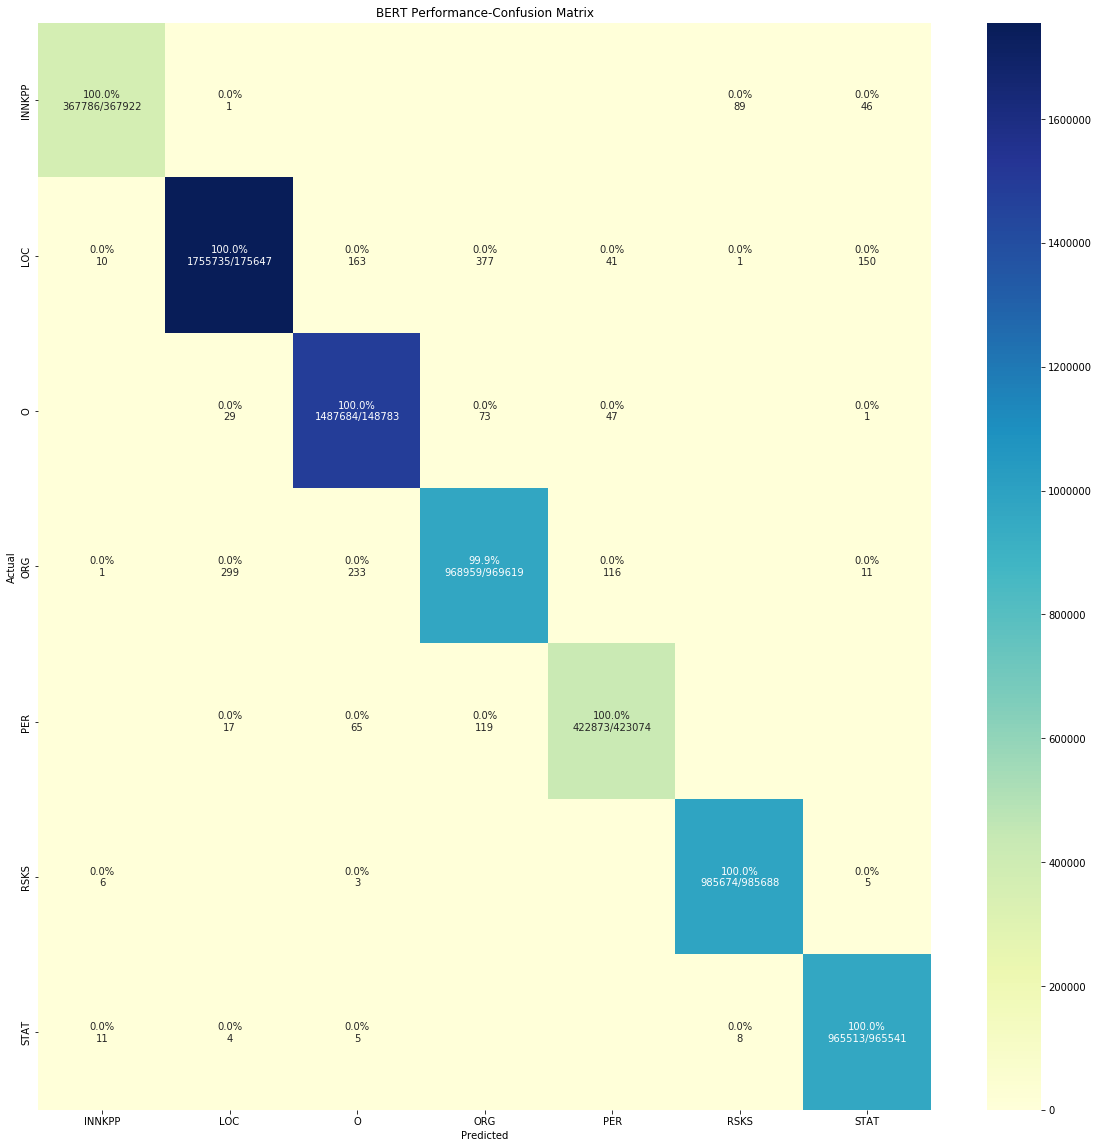

In [42]:
# true_predictions, references=true_labels


# y_predict=model.predict(valid, verbose=1)
# y_predict[ y_predict> 0.5] = 1
# y_predict[y_predict <= 0.5] = 0
plot_cm(tl, pl, 'BERT Performance-Confusion Matrix')

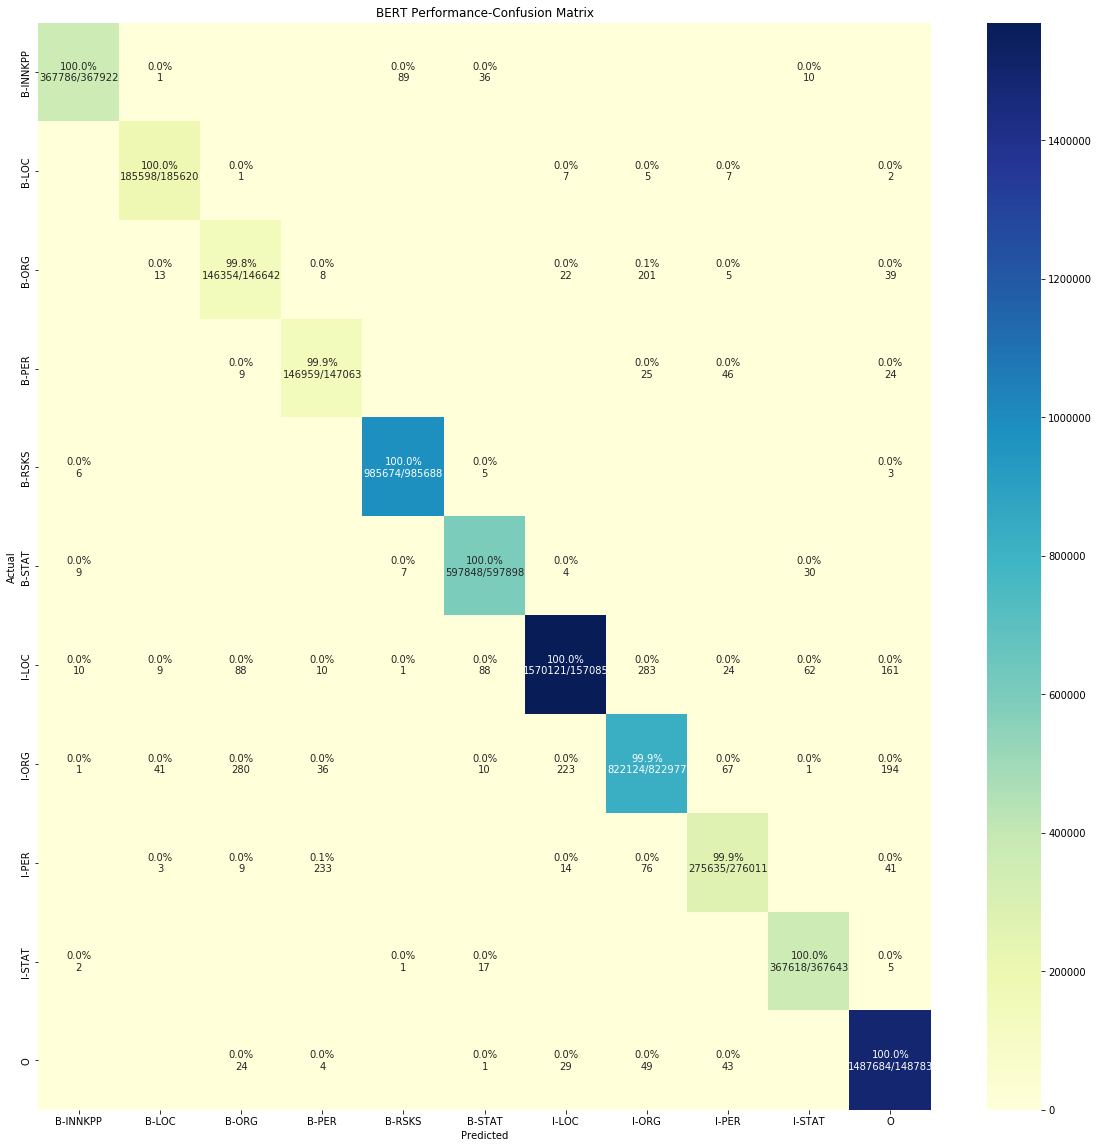

In [43]:
plot_cm(tll, pll, 'BERT Performance-Confusion Matrix')

In [52]:
# model.save_pretrained(BASE_DIR.joinpath('models/ner_dpbert_20epoch_93f1_97acc.bin'))

In [44]:
trainer.save_model(BASE_DIR.joinpath('models/ner_dpbert_4epoch_99f1ORG_99acc.bin'))

In [99]:
import joblib

joblib.dump(tokenizer, BASE_DIR.joinpath('models/ner_dpbert_20epoch_93f1_97acc.bin/tokenizer.joblib'))

['/home/ewp/DEV/ld_ner_bert_learn/models/ner_dpbert_20epoch_93f1_97acc.bin/tokenizer.joblib']

# Применение модели

In [53]:
import torch

In [56]:
text = 'ИП Герасинюк Ибраим Насртдинович 00112940 9204000492/92040100I 40702810500000007563 ООО "ЛИТЛТОН"  №вНГтват== 299011 г. Севастополь ул. Адмирала Октябрьского д. 13 офис 1 тел (0692) 671710 ‚  в Банк "ТААТТА"АО г. Иркутск БИК 049805709 кор. счет 30101810300000000709 по ОКПО'
text ='Субподрядчик СЕВЕРНОЕ ЛИНЕЙНОЕ ПРОИЗВОДСТВЕННОЕ УПРАВЛЕНИЕ МАГИСТРАЛЬНЫХ ГАЗОПРОВОДОВ (СЕВЕРНОЕ ЛПУМГ) Цорвя 631226435882 ГОРОД МОСКВА УЛИЦА УСАЧЁВА ДОМ 24 Филиал банка Плательщик ООО Банк "Саратов" тел. 8 344 741 9083 БИК'

In [57]:
tokens = tokenizer(text, return_tensors='pt')
tokens = {k: v.to(model.device) for k, v in tokens.items()}

with torch.no_grad():
    pred = model(**tokens)
pred.logits.shape

torch.Size([1, 55, 13])

In [79]:
pred.logits[0].max(dim=-1)#[0].cpu().numpy()

torch.return_types.max(
values=tensor([ 4.4739,  8.3717,  8.9862,  6.7887,  7.1319,  4.4768,  7.7785,  9.2805,
         6.0497,  7.1528,  7.6486,  6.7208,  9.1128,  9.2753,  8.9809,  8.4502,
         7.8720,  6.9571,  4.6823,  5.8118,  5.5143,  8.2660,  8.5086,  9.4773,
         8.6061,  4.6806, 11.2718, 10.2575, 12.2860, 12.6740, 10.3070, 12.9114,
        15.4671, 11.5672,  5.9719,  6.8736,  7.4390,  7.5124,  7.2453,  9.4588,
         9.7072,  6.7978,  7.8759,  9.1757,  8.3047,  6.9670,  6.4838,  6.3781,
        10.6794, 10.8630, 14.4948, 13.0483,  9.2627,  4.1351,  4.0556],
       device='cuda:0'),
indices=tensor([ 7,  0,  0,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,
         0,  0,  7,  9,  7,  7,  9,  7,  5,  6,  6,  6,  6,  6,  6,  6,  0,  0,
         0,  0,  0,  3,  3,  4,  4,  4,  4,  4,  0,  0, 11, 12, 12, 12, 12,  0,
         0], device='cuda:0'))

In [58]:
indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
for t, idx in zip(token_text, indices):
    print(f'{t:15s} {label_list[idx]:10s}')

[CLS]           B-INNKPP  
субподряд       O         
##чик           O         
северное        B-ORG     
лине            I-ORG     
##иное          I-ORG     
производственное I-ORG     
управление      I-ORG     
магистральных   I-ORG     
газопроводов    I-ORG     
(               I-ORG     
северное        I-ORG     
л               I-ORG     
##пу            I-ORG     
##м             I-ORG     
##г             I-ORG     
)               I-ORG     
ц               O         
##орв           O         
##я             O         
631             B-INNKPP  
##22            B-RSKS    
##64            B-INNKPP  
##35            B-INNKPP  
##88            B-RSKS    
##2             B-INNKPP  
город           B-LOC     
москв           I-LOC     
##а             I-LOC     
улица           I-LOC     
уса             I-LOC     
##чева          I-LOC     
дом             I-LOC     
24              I-LOC     
филиал          O         
банка           O         
плате           O         


In [66]:
len(token_text)

55

In [96]:
print(list(indices))

[1, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 9, 9, 7, 9, 7, 7, 7, 9, 9, 3, 3, 4, 4, 6, 4, 4, 4, 6, 6, 0, 6, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 11, 11, 12, 12, 12, 12, 12, 0, 6, 0, 4, 4, 4, 4, 3, 3, 4, 4, 4, 6, 0, 11, 11, 11, 11, 11, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0]


In [96]:
print(label_list)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-INNKPP', 'I-INNKPP', 'B-RSKS', 'I-RSKS', 'B-STAT', 'I-STAT']


In [6]:
'Инвестор МУП МП ГОРОДСКОГО ОКРУГА САМАРА КРАСНОГЛИНСКИЕ БАНИ Адрес филиала банка Брянская область, город Новозыбков Банк Инвестор ИНН/КПП 100601303468 / 632501001 тел. +7-830-199-8031 корр. счет 30310411361955797442'[9:60]

'МУП МП ГОРОДСКОГО ОКРУГА САМАРА КРАСНОГЛИНСКИЕ БАНИ'